# Batch Geocoding

The `batch_geocode()` function in the `arcgis.geocoding` module geocodes an entire list of addresses. Geocoding many addresses at once is also known as bulk geocoding.

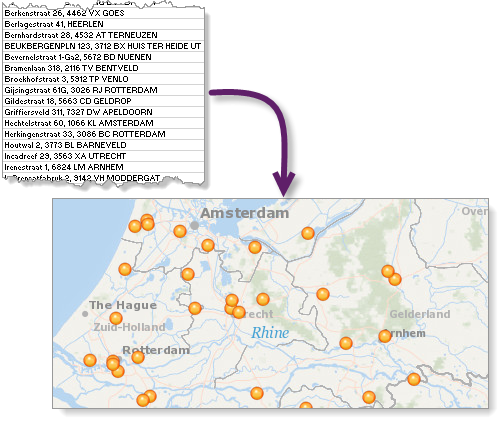

This method can be used to find the following types of locations:

* Street addresses:
 * 27488 Stanford Ave, Bowden, North Dakota
 * 380 New York St, Redlands, CA 92373
* Administrative place names, such as city, county, state, province, or country names:
 * Seattle, Washington
 * State of Mahārāshtra
 * Liechtenstein
* Postal codes:
 * 92591
 * TW9 1DN

Note:
Points of interest (POI) can only be batch geocoded by using the category parameter to specify the place types to geocode.

The addresses in your table can be stored in a single field or in multiple fields — one for each address component. Batch geocoding performance is better when the address parts are stored in separate fields.

In this guide, we will observe:
 - [Maximum addresses](#maximum-addresses)
 - [Batch geocode access](#batch-geocode-access)
 - [`batch_geocode()` function signature and parameters](#batch-geocode-function-signature-and-parameters)
   - [`addresses` parameter](#addresses-parameter)
   - [`category` parameter](#category-parameter)
   - [`source_country` parameter](#source-country-parameter)
   - [`out_sr` parameter](#out-sr-parameter)
   - [Batch geocoding output fields](#batch-geocoding-output-fields)
 - [Examples](#examples)
 - [Category filtering](#category-filtering)

<div class="alert alert-info">
**Tip:** You can also batch geocode address tables using the `gis.content.import_data()` and `item.publish()` methods. These are higher-level APIs that simplify the batch geocoding process.
</div>

<a id="maximum-addresses"></a>
## Maximum addresses

There is a limit to the maximum number of addresses that can be geocoded in a single batch request with the geocoder. The MaxBatchSize property defines this limit. For instance, if MaxBatchSize=2000, and 3000 addresses are sent as input, only the first 2000 will be geocoded. The SuggestedBatchSize property is also useful as it specifies the optimal number of addresses to include in a single batch request.

Both of these properties can be determined by querying the geocoder: 

In [2]:
from arcgis.gis import GIS
from arcgis.geocoding import get_geocoders, batch_geocode

gis = GIS("http://www.arcgis.com", "username", "password")

# use the first of GIS's configured geocoders
geocoder = get_geocoders(gis)[0]

In [2]:
print("MaxBatchSize : " + str(geocoder.properties.locatorProperties.MaxBatchSize))
print("SuggestedBatchSize : " + str(geocoder.properties.locatorProperties.SuggestedBatchSize))

MaxBatchSize : 1000
SuggestedBatchSize : 150


The client application must account for the limit by dividing the input address table into lists of `MaxBatchSize` or fewer addresses, and send each list to the service as a separate request. Note that the `gis.content.import_data()` and `item.publish()` methods take care of this for you.

**For batch geocode operations, the geocoder returns a response when each address in the input recordset has been geocoded. If an unhandled error such as a timeout occurs during the process, the geocoder will not return the results for that call, even if most of the addresses in the input have already been geocoded. For this reason, the client application should implement logic to detect and handle such errors.**

<a id="batch-geocode-access"></a>
## Batch geocode access

<p> 

<div class="alert alert-info">

An ArcGIS Online organizational account is required to use the batch geocoding functionality provided by the World Geocoding Service. Successfully geocoded addresses, which return a status of Matched or Tied, cause ArcGIS Online service credits to be consumed for batch geocoding operations.
</div>

<a id="batch-geocode-function-signature-and-parameters"></a>
## batch_geocode() function signature and parameters

The `batch_geocode()` function supports searching for lists of places and addresses. Each address in the list can be specified as a single line of text (single field format), or in multi-field format with the address components separated into mulitple parameters.

The code snippet below imports the geocode function and displays its signature and parameters along with a brief description:

In [3]:
help(batch_geocode)

Help on function batch_geocode in module arcgis.geocoding._functions:

batch_geocode(addresses, source_country=None, category=None, out_sr=None, geocoder=None)
    The batch_geocode() function geocodes an entire list of addresses.
    Geocoding many addresses at once is also known as bulk geocoding.
    
    Inputs:
    
       addresses - A list of addresses to be geocoded.
       For passing in the location name as a single line of text —
       single field batch geocoding — use a string.
       For passing in the location name as multiple lines of text
       multifield batch geocoding — use the address fields described
       in the Geocoder documentation.
        The maximum number of addresses that can be geocoded in a
        single request is limited to the SuggestedBatchSize property of
        the locator.
        Syntax:
         addresses = ["380 New York St, Redlands, CA",
         "1 World Way, Los Angeles, CA",
         "1200 Getty Center Drive, Los Angeles, CA",
      

<a id="addresses-parameter"></a>
### addresses parameter

A list of addresses to be geocoded. 
 - For passing in the location name as a single line of text — single field batch geocoding — use a string.
 - For passing in the location name as multiple lines of text — multifield batch geocoding — use the address fields described in the Geocoder documentation.

The Geocoder provides localized versions of the input field names in all locales supported by it. See the topic `Localized input field names` in the Geocoder documentation for more information.

### Example: batch geocode using single line addresses

In [4]:
addresses = ["380 New York St, Redlands, CA", 
             "1 World Way, Los Angeles, CA",
             "1200 Getty Center Drive, Los Angeles, CA", 
             "5905 Wilshire Boulevard, Los Angeles, CA",
             "100 Universal City Plaza, Universal City, CA 91608",
             "4800 Oak Grove Dr, Pasadena, CA 91109"]

In [5]:
results = batch_geocode(addresses)

In [6]:
map = gis.map("Los Angeles", 9)
map

![sample output](http://esri.github.io/arcgis-python-api/notebooks/nbimages/guide_tools_batchGeocoding_01.png)

In [7]:
for address in results:
    map.draw(address['location'])

Each match has keys for `score`, `location`, `attributes` and `address` properties:

In [8]:
results[0].keys()

dict_keys(['score', 'attributes', 'address', 'location'])

<a id="category-parameter"></a>
### category parameter

A place or address type which can be used to filter batch geocoding results. The parameter supports input of single category values or multiple comma-separated values. See the help topic <a href="/rest/geocode/api-reference/geocoding-category-filtering.htm">Category filtering</a> for complete details about the category parameter.

Example of category filtering with a single category:

<code>category="Address"</code>

Example of category filtering with multiple categories:

<code>category="Address,Postal"</code>


<a id="source-country-parameter"></a>
### source_country parameter

A value representing the country. When a value is passed for this parameter, all of the addresses in the input table are sent to the specified country locator to be geocoded. For example, if `sourceCountry="USA"` is passed in a `batch_geocode()` call, it is assumed that all of the addresses are in the United States, and so all of the addresses are sent to the USA country locator. Using this parameter can increase batch geocoding performance when all addresses are within a single country.

Acceptable values include the full country name, the ISO 3166-1 2-digit country code, or the ISO 3166-1 3-digit country code.

A list of supported countries and codes is available <a href="/rest/geocode/api-reference/geocode-coverage.htm">here</a>.

Example:

<code>source_country="USA"</code>

<a id="out-sr-parameter"></a>
### out_sr parameter

The spatial reference of the x/y coordinates returned by the geocode method. This is useful for applications using a map with a spatial reference different than that of the geocoder.

The spatial reference can be specified as either a well-known ID (WKID) or as a <a href="http://resources.arcgis.com/EN/HELP/REST/APIREF/GEOMETRY.HTML#SR">JSON spatial reference object</a>. If outSR is not specified, the spatial reference of the output locations is the same as that of the geocoder. The World Geocoding Service spatial reference is `WGS84 (WKID = 4326)`.

For a list of valid WKID values, see <a href="http://resources.arcgis.com/EN/HELP/REST/APIREF/PCS.HTML">Projected Coordinate Systems</a> and <a href="http://resources.arcgis.com/EN/HELP/REST/APIREF/GCS.HTML">Geographic Coordinate Systems</a>.

Example:

<code>out_sr=102100</code> 
##(102100 is the WKID for the Web Mercator projection)

<a id="batch-geocoding-output-fields"></a>
### Batch geocoding output fields

When you geocode a list of addresses, the output fields are returned as part of the attributes in the response. See the example JSON response below which shows all of the output fields that are returned for each record from a batch geocode process. The output fields are described <a href="/rest/geocode/api-reference/geocoding-service-output.htm#ESRI_SECTION1_42D7D3D0231241E9B656C01438209440">here</a>.

<a id="examples"></a>
## Batch geocoding examples

The earlier example showed how to call batch_geocode() with single line addresses. The following example illustrates how to call batch_geocode() with a list of multi-field addresses. 

### Example: Batch geocode using multiple field addresses

In [9]:
addresses= [{
                "Address": "380 New York St.",
                "City": "Redlands",
                "Region": "CA",
                "Postal": "92373"
            },{
                "Address": "1 World Way",
                "City": "Los Angeles",
                "Region": "CA",
                "Postal": "90045"
            }]

In [10]:
results = batch_geocode(addresses)

In [11]:
map = gis.map("Los Angeles", 9)
map

![sample output](http://esri.github.io/arcgis-python-api/notebooks/nbimages/guide_tools_batchGeocoding_02.png)

In [12]:
for address in results:
    map.draw(address['location'])

<a id="category-filtering"></a>
## Category filtering

The batch_geocode() method supports batch geocode filtering by category values, which represent address and place types. By including the category parameter in a batch_geocode() call you can avoid false positive matches to unexpected place and address types due to ambiguous input.

For example, a user has a table of three-letter airport codes that they want to geocode. There may be city or business names that are the same as an airport code, causing false positive matches to other places. However the user can ensure that only airport matches are returned by specifying `category="airport"` in the request.

### Example: Batch geocode airport codes with category

In [13]:
airports = batch_geocode(["LAX", "SFO", "ONT", "FAT", "LGB"], category="airport")

In [14]:
map = gis.map("CA", 6)
map

![sample output](http://esri.github.io/arcgis-python-api/notebooks/nbimages/guide_tools_batchGeocoding_03.png)

In [15]:
for airport in airports:
    popup = { 
    "title" : airport['attributes']['PlaceName'], 
    "content" : airport['address']
    }
    map.draw(airport['location'], popup)

You can also use category filtering to avoid `"low resolution" fallback matches`. By default if the World Geocoding Service cannot find a match for an input address it will automatically search for a lower match level, such as a street name, city, or postal code. For batch geocoding a user may prefer that no match is returned in such cases so that they are not charged for the geocode. If a user passes `category="Point Address,Street Address"` in a batch_geocode() call, no fallback will occur if address matches cannot be found; the user will only be charged for the actual address matches.

### Example: Batch geocode with fallback allowed (no category)

In the example below, the second address is not matched to a point address, but is matched to the city instead, due to fallback: 

In [16]:
results = batch_geocode(["380 New York St Redlands CA 92373",
                         "27488 Stanford Dr Escondido CA"])

In [17]:
for result in results:
    print("Score " + str(result['score']) + " : " + result['address'])

Score 100 : 380 New York St, Redlands, California, 92373
Score 100 : Escondido, California


### Example: Batch geocode with no fallback allowed (category="Point Address")
In the example below, as a point address match is not found for the second address, there is no low resolution fallback as the category has been set to Point Address, and no match is returned for the second address:

In [18]:
results = batch_geocode(["380 New York St Redlands CA 92373", 
                         "27488 Stanford Dr Escondido CA"],
                         category="Point Address")

In [19]:
for result in results:
    print("Score " + str(result['score']) + " : " + result['address'])

Score 100 : 380 New York St, Redlands, California, 92373
Score 0 : 
